## Scrape NCBI for Genome Stats!!! ##

The goal of this script is to automagically get a nice table and figure describing the state of the EBP in terms of genomes available at NCBI!  
The link is https://www.ncbi.nlm.nih.gov/assembly?term=eucaryotes  
The plan is to download the table, parse the data and present it a nice way automatically for easy updates in the future.

### List of graphs and charts I want to make:
1. Assembly quality - x axis contig, y axis scaffold **Done!**
2. EBP quality assemblies by year      **Sorta - go back and Redo!**
3. Draft quality assemblies by year      **Sorta - go abck and Redo!**
4. Families with an EBP quality assembly by year  **Done!**
5. Families with a draft quality assembly by year   **Done!**
6. Total assemblies or any kind by year **Done!**
7. Families with an assembly of any kind by year **Done!**
8. Funding by country (by species) **Done!**
9. Phase 1 Funding by number of families  - hmmm
10. Funding by conversations ongoing...  **Done!**
11. Long read costs, read lengths and qualities
12. Estimated costs per assembly (Long reads + HiC + Assembly) (perhaps historical?)
13. Assemblies sliced by quality and taxonomic group - playing with!


SO on playing with this a bit more, the easiest thing seems to be to get the XML format file from NCBI.

1. Do this search by clicking this link:
https://www.ncbi.nlm.nih.gov/assembly?term=eucaryotes

2. Click on "send to" - choose destination "file" set the format to "XML" (to get all the data), sort by "Contig N50 down" and finally "Create file"

3. This will download a file called "assembly_result.xml" which is the input to the parsing script.

4. Put this file in the same directory as the images "NCBI_Genome_stats_images" - so the script knows where to look for it.

![Title](NCBI_Genome_stats_images/NCBI_search_screenshot_Aug_2019.png)

### Some code to take the xml and make a tab delimited file to read into pandas ###

In [1]:
# I'm playing with this now - to make it better
!wget https://www.ncbi.nlm.nih.gov/portal/utils/file_backend.cgi?Db=assembly&HistoryId=NCID_1_19669352_130.14.22.76_5555_1567630061_2685082395_0MetA0_S_HStore&QueryKey=1&Sort=CONTIGN50&Filter=all&CompleteResultCount=9253&Mode=file&View=xml&p$l=Email&portalSnapshot=%2Fprojects%2FGenome%2FAssemblyDB%2FAssembly_EntrezPackage%401.34&BaseUrl=&PortName=live&FileName=&ContentType=xml > ncb_xml_file
!head ncb_xml_file

/bin/sh: wget: command not found
/bin/sh: p=Email: command not found


In [2]:
# Now import the file, and parse the xml!
# I will do this as it is a straight text file - as I think that is easier than fucking around with xml that gives errors in other peoples parsers
# for now just make a tab delimited file and open it in pandas

import re

#xml_file = "NCBI_Genome_stats_images/head_1000_assembly_result.xml"
xml_file = "NCBI_Genome_stats_images/assembly_result.xml"
out_file = xml_file + "_tab_delimited_file.txt"
fhout = open(out_file, mode='w')
fhout.write("species\tcontig_n50\tscaffold_n50\tstatus\tass_accession\tass_release_date\n")
species_count = 0
with open(xml_file) as xml_fh:
    for line in xml_fh:
        
        search_obj_acc = re.search('<AssemblyAccession>(.+)<', line)
        search_obj_species = re.search('<SpeciesName>(.+)</SpeciesName>', line)
        search_obj_ass_status = re.search('<AssemblyStatus>(.+)</AssemblyStatus>', line)
        search_obj_ass_release_date = re.search('<AsmReleaseDate_GenBank>(\d+/\d+/\d+).+</AsmReleaseDate_GenBank>', line)
        search_obj_contig_n50 = re.search('<ContigN50>(\d+)</ContigN50>', line)
        search_obj_scaf_n50 = re.search('<ScaffoldN50>(.+)</ScaffoldN50>', line)
        search_obj_end_record = re.search('</DocumentSummary>', line)

        if search_obj_acc:
            ass_accession = search_obj_acc.group(1)
            #print(search_obj_acc.group(1))
        if search_obj_species:
            species = search_obj_species.group(1)
            #print(search_obj_species.group(1))
        if search_obj_ass_status:
            status = search_obj_ass_status.group(1)
            #print(search_obj_ass_status.group(1))
        if search_obj_ass_release_date:
            ass_release_date = search_obj_ass_release_date.group(1)
            #print(search_obj_ass_release_date.group(1))
        if search_obj_contig_n50:
            contig_n50 = search_obj_contig_n50.group(1)
            #print(search_obj_contig_n50.group(1), "bp")
        if search_obj_scaf_n50:
            scaffold_n50 = search_obj_scaf_n50.group(1)
            #print("scaffold_n50 =", scaffold_n50)
            #print(search_obj_scaf_n50.group(1), "bp")
        if search_obj_end_record:
            print_line = species + "\t" + contig_n50 + "\t" + scaffold_n50 + "\t" +  status + "\t" + ass_accession + "\t" + ass_release_date + "\n"
            #print(print_line)
            fhout.write(print_line)
            species_count = species_count + 1
print("species_count = ", species_count)
fhout.close()

species_count =  9477


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [4]:
#df = pd.read_csv("NCBI_Genome_stats_images/assembly_result.xml_tab_delimited_file.txt", delimiter="\t")
df = pd.read_csv(out_file, delimiter="\t")

In [5]:
df.head(3)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01
1,Sus scrofa,52150866,138999934,Chromosome,GCA_006511355.1,2019/07/03
2,Sus scrofa,48231277,88231837,Chromosome,GCF_000003025.6,2017/02/14


In [6]:
df['species'].count()

9477

In [7]:
# try to remove duplicate species, but keep the longest contig N50
df_sorted_no_dups = df.sort_values('contig_n50', ascending=False).drop_duplicates(subset=['species'])
df_sorted_no_dups = df_sorted_no_dups.reset_index(drop=True)
df_sorted_no_dups.head(3)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01
1,Sus scrofa,52150866,138999934,Chromosome,GCA_006511355.1,2019/07/03
2,Macaca mulatta,46608966,82346004,Chromosome,GCF_003339765.1,2019/03/13


In [8]:
df_sorted_no_dups['species'].count()

4590

In [9]:
df_sorted_no_dups['status'].describe()

count         4590
unique           4
top       Scaffold
freq          3320
Name: status, dtype: object

### Grab genera from species name 

In [10]:
new_df = df_sorted_no_dups['species'].str.split(" ", n=1, expand=True)
print(new_df.head(2))
df_sorted_no_dups['genera'] = new_df[0]
df_sorted_no_dups.head()

      0        1
0  Homo  sapiens
1   Sus   scrofa


,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,genera
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01,Homo
1,Sus scrofa,52150866,138999934,Chromosome,GCA_006511355.1,2019/07/03,Sus
2,Macaca mulatta,46608966,82346004,Chromosome,GCF_003339765.1,2019/03/13,Macaca
3,Bos grunniens,44716738,114386978,Chromosome,GCA_005887515.1,2019/06/10,Bos
4,Felis catus,41915695,83967707,Chromosome,GCF_000181335.3,2017/11/20,Felis


## Function to add higher taxonomic info to dataframe to allow by family or kingdom ect ##

In [11]:
# function to take a pandas lambda df thing species name and return a family name using the above ideas
### WHAT A COMPLETE PAIN IN THE ASS TO FIND OUT THIS IS WHAT WAS NEEDED
import requests
import re

def DF_get_family_name_given_species_name(df):
    """
    This is a short function to get a family name from the GBIF rest api given a genus_species name
    example input: Homo sapiens
    example return: Hominidae
    It requires re, requests functions
    NOTE!!! - Homo Sapiens doesn't work, Homo sapiens does - CHECK SPELLING
    """
    family = ''
    order = ''
    taxon_class = ''
    phylum = ''
    
    search_url_string = "http://api.gbif.org/v1/species/match?&name=" + df['species']
    res = requests.get(search_url_string)
    if res.status_code == 200:
        #print(res.text)
        #print("search string = ", search_url_string)
        search_obj_family = re.search(',"family":"(.+?)",', res.text)
        if search_obj_family:
            family = search_obj_family.group(1)
        else:
            #print("no family name returned for species name:", species)
            print(".", end="")
            family = None
        
        search_obj_order = re.search(',"order":"(.+?)",', res.text)
        if search_obj_order:
            order = search_obj_order.group(1)
        else:
            #print("no order name returned for species name:", species)
            print(".", end="")
            order = None
        
        search_obj_class = re.search(',"class":"(.+?)"', res.text)
        if search_obj_class:
            taxon_class = search_obj_class.group(1)
        else:
            #print("no class name returned for species name:", species)
            print(".", end="")
            taxon_class = None
        
        search_obj_phylum = re.search(',"phylum":"(.+?)"', res.text)
        if search_obj_phylum:
            phylum = search_obj_phylum.group(1)
        else:
            #print("no phylum name returned for species name:", species)
            print(".", end="")
            phylum = None
            
        search_obj_kingdom = re.search(',"kingdom":"(.+?)"', res.text)
        if search_obj_kingdom:
            kingdom = search_obj_kingdom.group(1)
        else:
            #print("no kingdom name returned for species name:", species)
            print(".", end="")
            kingdom = None
            
        #print("got:", family, order, taxon_class, phylum, kingdom)
        df['family'] = family
        df['order'] = order
        df['class'] = taxon_class
        df['phylum'] = phylum
        df['kingdom'] = kingdom
    
    return(df)

# test this out - # Create the pandas DataFrame 
data = [['Homo sapiens', "test"], ['Drosophila melanogaster', "test 2"]] 
df_test_taxon = pd.DataFrame(data, columns = ['species', 'something']) 
print(df_test_taxon)  

# test the above function
df_test_taxon = df_test_taxon.apply(DF_get_family_name_given_species_name, axis=1)
df_test_taxon

                   species something
0             Homo sapiens      test
1  Drosophila melanogaster    test 2


,species,something,family,order,class,phylum,kingdom
0,Homo sapiens,test,Hominidae,Primates,Mammalia,Chordata,Animalia
1,Drosophila melanogaster,test 2,Drosophilidae,Diptera,Insecta,Arthropoda,Animalia


## Don't re-run this next cell unless redoing everything - it goes to GBIF for every species name - need to work on a full download too local storage. ##

In [12]:
# this takes time and goes to the Web for every species - uncomment line to redo as needed.
## uncomment the next line to run - takes 50 mins???
df_sorted_no_dups = df_sorted_no_dups.apply(DF_get_family_name_given_species_name, axis=1)
df_sorted_no_dups.head(3)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,genera,family,order,class,phylum,kingdom
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia
1,Sus scrofa,52150866,138999934,Chromosome,GCA_006511355.1,2019/07/03,Sus,Suidae,Artiodactyla,Mammalia,Chordata,Animalia
2,Macaca mulatta,46608966,82346004,Chromosome,GCF_003339765.1,2019/03/13,Macaca,Cercopithecidae,Primates,Mammalia,Chordata,Animalia


### Plot of Contig N50 vs Scaffold N50

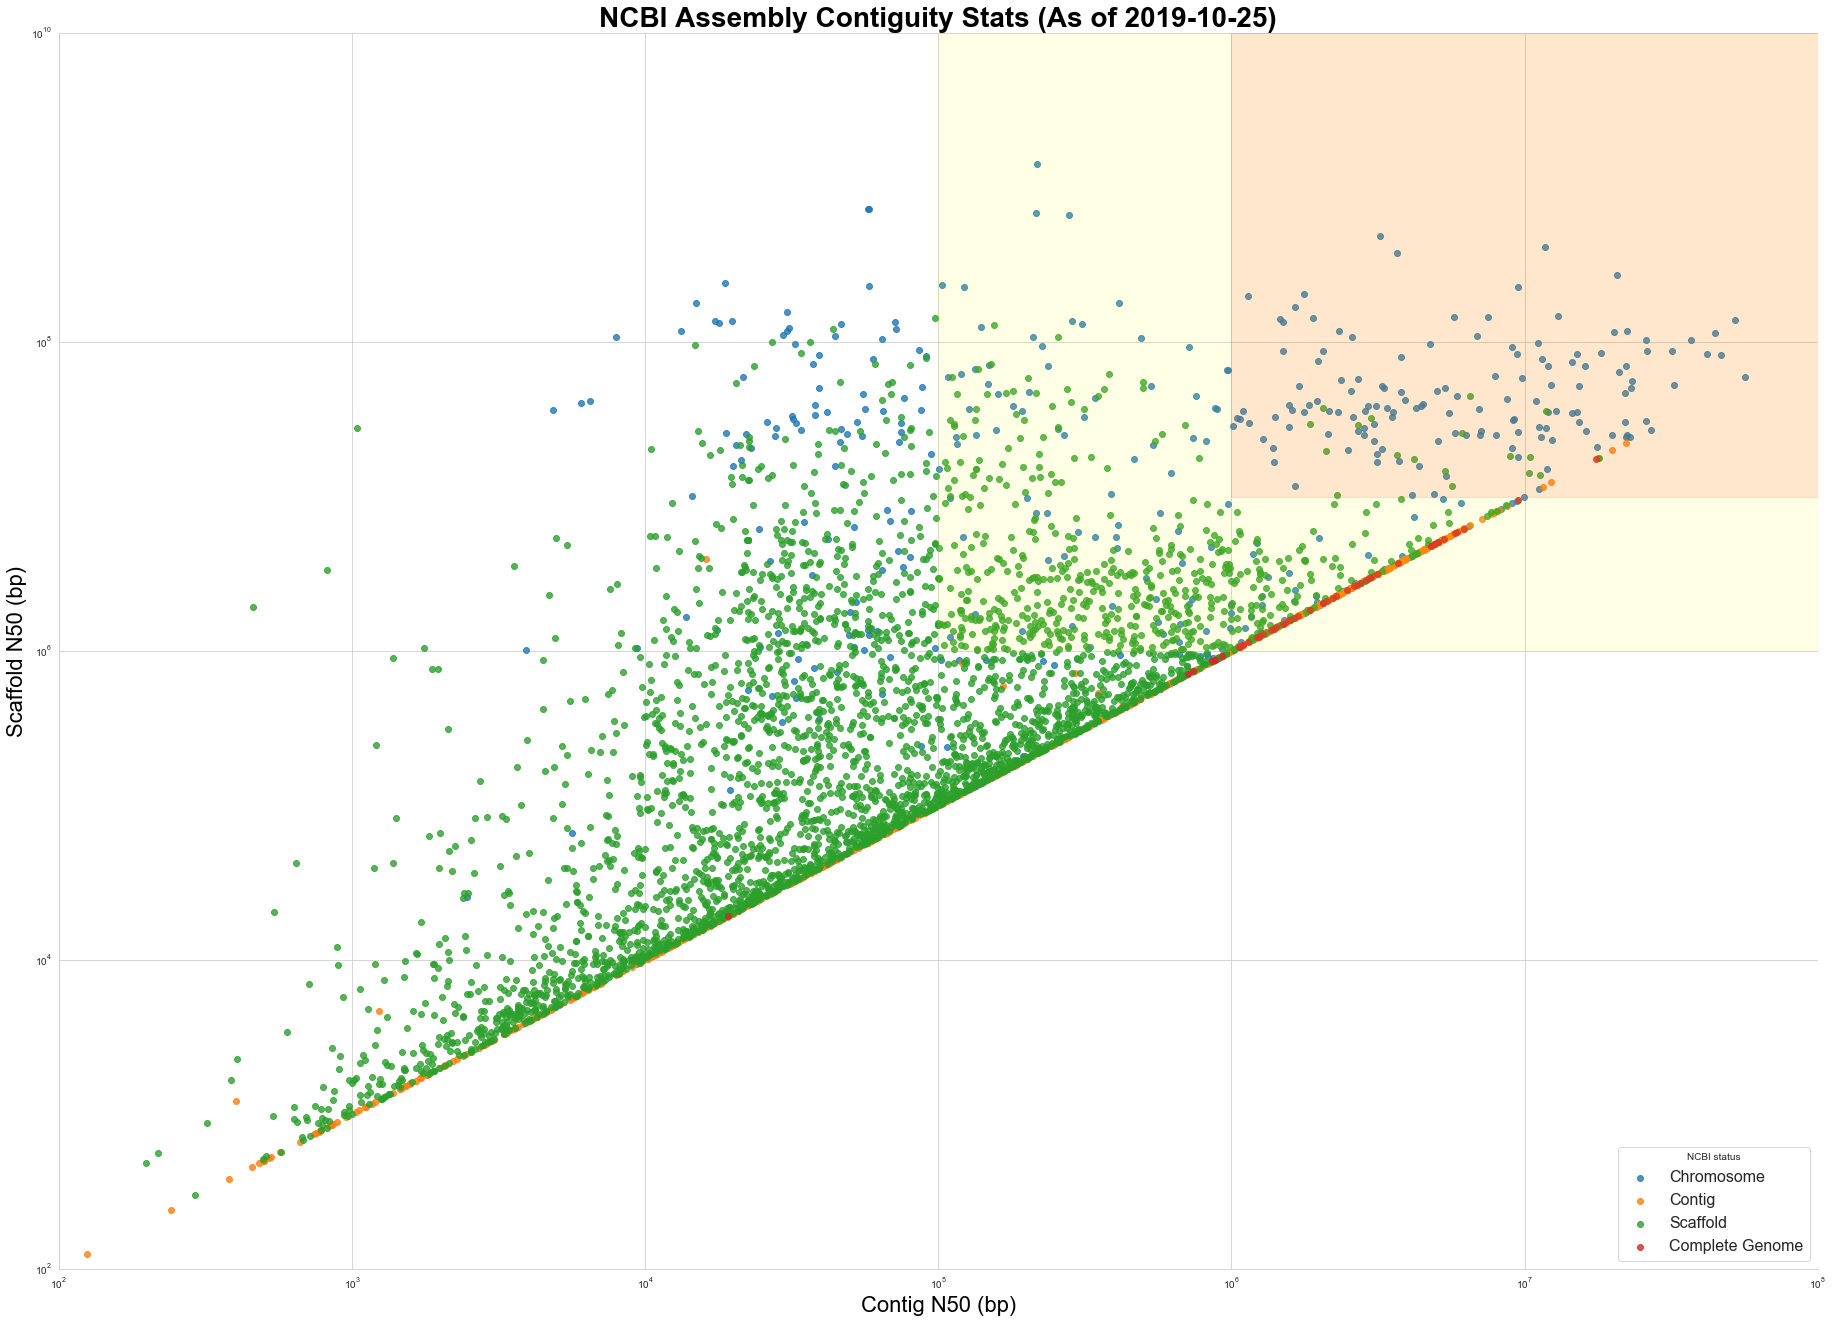

In [13]:
date = datetime.date.today()
sns.set_style("whitegrid")

g = sns.lmplot(x='contig_n50', y='scaffold_n50', data=df_sorted_no_dups, hue='status', fit_reg=False, height=18, aspect=1.4, legend_out=False)

# Set the `yscale` and other things
g.set(yscale="log")
g.set(xscale="log")
g.set(ylim=[100, 10000000000])
g.set(xlim=[100, 100000000])

plt.axvspan(1000000, 10000000000, ymin=0.625, ymax=1, alpha=0.1, color='red')
plt.axvspan(100000, 1000000000, ymin=0.5, ymax=1, alpha=0.1, color='yellow')

plt.xlabel('Contig N50 (bp)', fontweight='normal', color = 'black', fontsize=22, horizontalalignment='center')
plt.ylabel('Scaffold N50 (bp)', fontweight='normal', color = 'black', fontsize=22, horizontalalignment='center')
title_string = "NCBI Assembly Contiguity Stats (As of " + str(date.today()) + ")" 
plt.title(title_string, fontweight='bold', color = 'black', fontsize='28', loc='center')
plt.legend(loc = 'lower right', title = "NCBI status", fontsize = 16)

# Show plot
#plt.show()
file_name = "NCBI_Genome_stats_images/Assembly_contiguity_stats_" + str(date.today()) + ".png"
plt.savefig(file_name)

In [14]:
# try and plot assemblies by year - first add year column to dataframe
df_sorted_no_dups['date_time_test'] = pd.to_datetime(df_sorted_no_dups['ass_release_date'])
df_sorted_no_dups['year'] = df_sorted_no_dups['date_time_test'].apply(lambda x: x.year)
print(type(df_sorted_no_dups['year'][0]))
df_sorted_no_dups.head(3)

<class 'numpy.int64'>


,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,genera,family,order,class,phylum,kingdom,date_time_test,year
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia,2019-03-01,2019
1,Sus scrofa,52150866,138999934,Chromosome,GCA_006511355.1,2019/07/03,Sus,Suidae,Artiodactyla,Mammalia,Chordata,Animalia,2019-07-03,2019
2,Macaca mulatta,46608966,82346004,Chromosome,GCF_003339765.1,2019/03/13,Macaca,Cercopithecidae,Primates,Mammalia,Chordata,Animalia,2019-03-13,2019


In [15]:
# MAKE A DATA FRAME WITH HIGH QUALITY ASSEMBLIES
df_contig_N50_OK = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>1000000]
#df_contig_N50_OK.tail()
df_scaf_and_contig_OK = df_contig_N50_OK[df_contig_N50_OK['scaffold_n50']>10000000]
df_complete_genome = df_sorted_no_dups[df_sorted_no_dups['status'] == 'Complete Genome']
df_all_passing = pd.concat([df_scaf_and_contig_OK, df_complete_genome])
df_all_passing = df_all_passing.drop_duplicates()
print("number of species passing VGP qual (no dups):", df_all_passing['species'].count())


number of species passing VGP qual (no dups): 214


In [16]:
df_draft_contig_N50_OK = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>100000]
#df_contig_N50_OK.tail()
df_draft_scaf_and_contig_OK = df_draft_contig_N50_OK[df_draft_contig_N50_OK['scaffold_n50']>1000000]
df_complete_genome = df_sorted_no_dups[df_sorted_no_dups['status'] == 'Complete Genome']
df_draft_all_passing = pd.concat([df_draft_scaf_and_contig_OK, df_complete_genome])
print("number of draft all passing = ", df_draft_all_passing['species'].count())
df_draft_all_passing = df_draft_all_passing.drop_duplicates()
print("number of draft all passing after dup removal = ", df_draft_all_passing['species'].count())  # seems to have worked


number of draft all passing =  1149
number of draft all passing after dup removal =  1106


In [17]:
# just for me
print("total number of NCBI assemblies = ", df_sorted_no_dups['species'].count())

total number of NCBI assemblies =  4590


## Write a nice report - this needs to be put into Markdown for an easy nice output

In [19]:
# make a summary stats file
import datetime
date = datetime.date.today()
print("date of NCBI stats download = ", date)

total_non_redundant_assemblies = df_sorted_no_dups['species'].count()
print("total_non_redundant_assemblies = ", total_non_redundant_assemblies)
NCBI_complete_genome_assemblies = df_sorted_no_dups[df_sorted_no_dups['status'] == "Complete Genome"]['species'].count()
print("NCBI complete genome status = ", NCBI_complete_genome_assemblies)
NCBI_chromosome_assemblies = df_sorted_no_dups[df_sorted_no_dups['status'] == "Chromosome"]['species'].count()
print("NCBI chromosome status = ", NCBI_chromosome_assemblies)
#print("Question: What is the definition of complete genome and or chromosome status at NCBI???")

print("\n")

contig_N50_greater_than_1Mb = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>1000000]['species'].count()
print("contig_N50_greater_than_1Mb =", contig_N50_greater_than_1Mb)

scaffold_n50_greater_than_10Mb = df_sorted_no_dups[df_sorted_no_dups['scaffold_n50']>10000000]['species'].count()
print("scaffold_n50_greater_than_10Mb =", scaffold_n50_greater_than_10Mb)

VGP_standard = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>=1000000][df_sorted_no_dups['scaffold_n50']>=10000000]['species'].count()
percent_VGP_standard = VGP_standard / 1500000 * 100
print("meets VGP standard (1Mb contig N50, 10Mb Scaffold N50) =", VGP_standard, "or", percent_VGP_standard, "%")


print("\n")
contig_N50_greater_than_100Kb = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>100000]['species'].count()
print("contig_N50_greater_than_100Kb =", contig_N50_greater_than_100Kb)

scaffold_n50_greater_than_1Mb = df_sorted_no_dups[df_sorted_no_dups['scaffold_n50']>1000000]['species'].count()
print("scaffold_n50_greater_than_1Mb =", scaffold_n50_greater_than_1Mb)

Lower_standard = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>=100000][df_sorted_no_dups['scaffold_n50']>=1000000]['species'].count()
percent_lower_standard = Lower_standard / 1500000 * 100
print("meets draft standard (100kb contig N50, 1Mb scaffold N50) =", Lower_standard, "or", percent_lower_standard, "%")

date of NCBI stats download =  2019-10-25
total_non_redundant_assemblies =  4590
NCBI complete genome status =  50
NCBI chromosome status =  427


contig_N50_greater_than_1Mb = 587
scaffold_n50_greater_than_10Mb = 409
meets VGP standard (1Mb contig N50, 10Mb Scaffold N50) = 165 or 0.011000000000000001 %


contig_N50_greater_than_100Kb = 2030
scaffold_n50_greater_than_1Mb = 1566
meets draft standard (100kb contig N50, 1Mb scaffold N50) = 1099 or 0.07326666666666666 %


/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### THE BELOW IS IN PROGRESS TO MAKE THE REPORT LOOK NICE ###

In [20]:
# print to markdown file for the poster:
FHOUT = open('NCBI_Genome_stats_images/stats_table.md', 'w')
FHOUT.write("""

date of NCBI stats download = %d



""")
Colons can be used to align columns.

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned | $1600 |
| col 2 is      | centered      |   $12 |
| zebra stripes | are neat      |    $1 |

   # 2. make the main markdown file
    report = '''
### Analysis of {}  
Reference = {}

**Total sequence = _{} bp_**  
**Good sequence = _{} bp ({}%)_**  
  
![alt text]({} "{}")

|                          |  All reads     | Alignable reads | Reads > 2kb and 80% ident |  >20kb, >80% ident |
|--------------------------|:--------------:|:---------------:|:-------------------------:|:------------------:|
| Number of reads          |   {}           |      {}         |        {} ({}%)           |     {} ({}%)       | 
| Total sequence (bp)      |   {}           |      {}         |        {} ({}%)           |     {} ({}%)       |
| Longest read (bp)        |   {}           |      {}         |        {}                 |           -        |       
| longest read accuracy (%)|   {}           |      {}         |        {}                 |           -        |
| Mean read length (bp)    |   {}           |      {}         |        {}                 |           -        |
| Median read length (bp)  |   {}           |      {}         |        {}                 |           -        |
| Max read length bin (bp) |   {}           |      {}         |        {}                 |           -        |
| Mean read accuracy (%)   |   {}           |      {}         |        {}                 |           -        |
| Median read accuracy (%) |   {}           |      {}         |        {}                 |           -        |
| Max read identity bin (%)|   {}           |       -         |         -                 |           -        |

Report generated using the script run_nanopore_alignment_and_stats_pipeline.py by Stephen Richards stephenr@bcm.edu  
Start time: {}, End time: {}, Run time: {}, Run time per Gb: {}  
Methods: ONT reads aligned with {}, identities identified with samtools calmd, stats generated using pandas.  
Cost per 100Gb 30X human genome with {}bp sequence yield runs = ${} on MinION assuming $1,000/run PromethION is ~half that cost at low volume and ~1/5th cost at high volume (${})
'''.format(output_name,
           ref,
           all_reads_seq,
           good_reads_seq,
           good_reads_seq_percent,
           histogram,
           histogram_text,
           num_reads,
           num_aligned_reads,
           num_good_reads,
           num_good_reads_percent,
           num_good_long_reads,
           num_good_long_reads_percent,
           all_reads_seq,
           aligned_reads_seq,
           good_reads_seq,
           good_reads_seq_percent,
           good_long_reads_seq,
           good_long_reads_seq_percent,
           longest_read,
           longest_aligned_read,
           longest_good_read,
           longest_read_ident,
           longest_aligned_read_ident,
           longest_good_read_ident,
           mean_read_length,
           mean_aligned_read_length,
           mean_good_read_length,
           peak_read_length,
           peak_aligned_read_length,
           peak_good_read_length,
           max_read_length_bin_all_reads,
           max_read_length_bin_aligned_reads,
           max_read_length_bin_good_reads,
           mean_read_accuracy,
           mean_aligned_read_accuracy,
           mean_good_read_accuracy,
           peak_read_accuracy,
           peak_aligned_read_accuracy,
           peak_good_read_accuracy,
           max_read_identity_bin,
           start_time,
           end_time,
           run_time,
           run_time_per_gb,
           aligner,
           good_reads_seq,
           cost_per_100gb, 
           promethION_cost_per_100gb)



SyntaxError: invalid syntax (<ipython-input-20-3ede895a08cc>, line 10)

## Question ##
### What is the definition of complete genome and chromosome status at NCBI??? ###

In [21]:
# use a pivot table to get number of families in df_all_passing
#df_all_passing_by_family = df_all_passing.pivot_table(columns="species" , values='family')
#df_all_passing_by_family
print("total number of passing species = ", df_all_passing['species'].count())

df_all_passing_by_family = pd.pivot_table(df_all_passing, index=['family'])
#df_all_passing_by_family = df_all_passing.groupby(by='family')
print(df_all_passing_by_family.count())
print("total number of passing families = ", df_all_passing_by_family['contig_n50'].count())

total number of passing species =  214
contig_n50      129
scaffold_n50    129
year            129
dtype: int64
total number of passing families =  129


In [22]:
# and again for draft quality
print("total number of passing species = ", df_draft_all_passing['species'].count())
df_draft_all_passing_by_family = pd.pivot_table(df_draft_all_passing, index=['family'])
df_draft_all_passing_by_family.count()

total number of passing species =  1106


contig_n50      397
scaffold_n50    397
year            397
dtype: int64

In [23]:
print("total species = ", df_all_passing['species'].count())
min_year = df_all_passing['year'].min()
max_year = df_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative VGP quality species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_assembly = df_all_passing[df_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing = ",  cum_species_with_assembly)
    lst.append([int(year_count), int(cum_species_with_assembly)])

df_cumulative_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species

total species =  214
min_year =  2010 max_year =  2019


,Year,Cumulative VGP quality species represented
0,2010,3
1,2011,6
2,2012,6
3,2013,7
4,2014,11
5,2015,16
6,2016,22
7,2017,39
8,2018,92
9,2019,214


In [24]:
print("total species = ", df_draft_all_passing['species'].count())
#min_year = df_draft_all_passing['year'].min()
min_year = 2010
max_year = df_draft_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative 100kb contig N50 species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_draft_assembly = df_draft_all_passing[df_draft_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing draft qual = ",  cum_species_with_draft_assembly)
    lst.append([int(year_count), int(cum_species_with_draft_assembly)])

df_cumulative_draft_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_draft_species

total species =  1106
min_year =  2010 max_year =  2019


,Year,Cumulative 100kb contig N50 species represented
0,2010,18
1,2011,49
2,2012,68
3,2013,98
4,2014,143
5,2015,200
6,2016,355
7,2017,516
8,2018,773
9,2019,1106


In [25]:
print("total species = ", df_sorted_no_dups['species'].count())
#min_year = df_sorted_no_dups['year'].min()
min_year = 2010  # because a lot of older assemblies had updates - so not much before 2010 unless you look at the originals
max_year = df_sorted_no_dups['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Any assembly: Cumulative species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_any_assembly = df_sorted_no_dups[df_sorted_no_dups['year'] <= year_count]['species'].count()
    #print("number of cumulative species any assembly quality = ",  cum_species_with_any_assembly)
    lst.append([int(year_count), int(cum_species_with_any_assembly)])

df_cumulative_species_any_assembly = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species_any_assembly

total species =  4590
min_year =  2010 max_year =  2019


,Year,Any assembly: Cumulative species represented
0,2010,79
1,2011,162
2,2012,272
3,2013,449
4,2014,745
5,2015,1125
6,2016,1620
7,2017,2228
8,2018,3456
9,2019,4590


### Note there are a lot of updated and not original genomes in here,  
- lots of old genome assemblies replaced by an updated version - seemed to happen a lot in 2010  
- So I made 2010 the first year of the plot for now  
- Will think about a more accurate historical view later

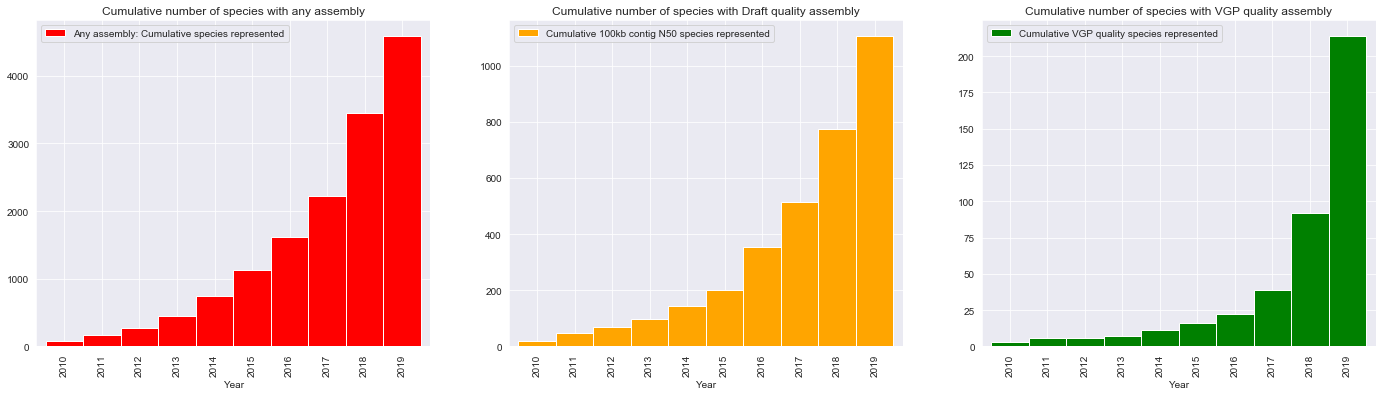

In [27]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(24,6))

df_cumulative_species_any_assembly.plot(ax=axes[0,0], x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly")
df_cumulative_draft_species.plot(ax=axes[0,1],  x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly')
df_cumulative_species.plot(ax=axes[0,2], x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly")

plt.savefig('NCBI_Genome_stats_images/Cumulative_species_by_year.png')

In [28]:
# keep cell in case I need a single plot
#sns.set_style('darkgrid')
#df_cumulative_species_any_assembly.plot(x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_any_assembly.png')

In [29]:
# Keep cell incase I need a single plot
#df_cumulative_draft_species.plot(x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly', figsize=(8,6))
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_Draft_quality_assembly.png')

In [30]:
# Keep cell in case I need a single plot
#df_cumulative_species.plot(x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_EBP_quality_assembly.png')

## Now I need to plot the same progress by different taxonomic rank  
- If I were smart this would be a cool loop with three charts for each rank in a cool grid pattern

In [31]:
df_all_passing.head(1)

,species,contig_n50,scaffold_n50,status,ass_accession,ass_release_date,genera,family,order,class,phylum,kingdom,date_time_test,year
0,Homo sapiens,56413054,59364414,Chromosome,GCF_000001405.39,2019/03/01,Homo,Hominidae,Primates,Mammalia,Chordata,Animalia,2019-03-01,2019



total species at this quality =  4590

total species at this quality =  1106

total species at this quality =  214


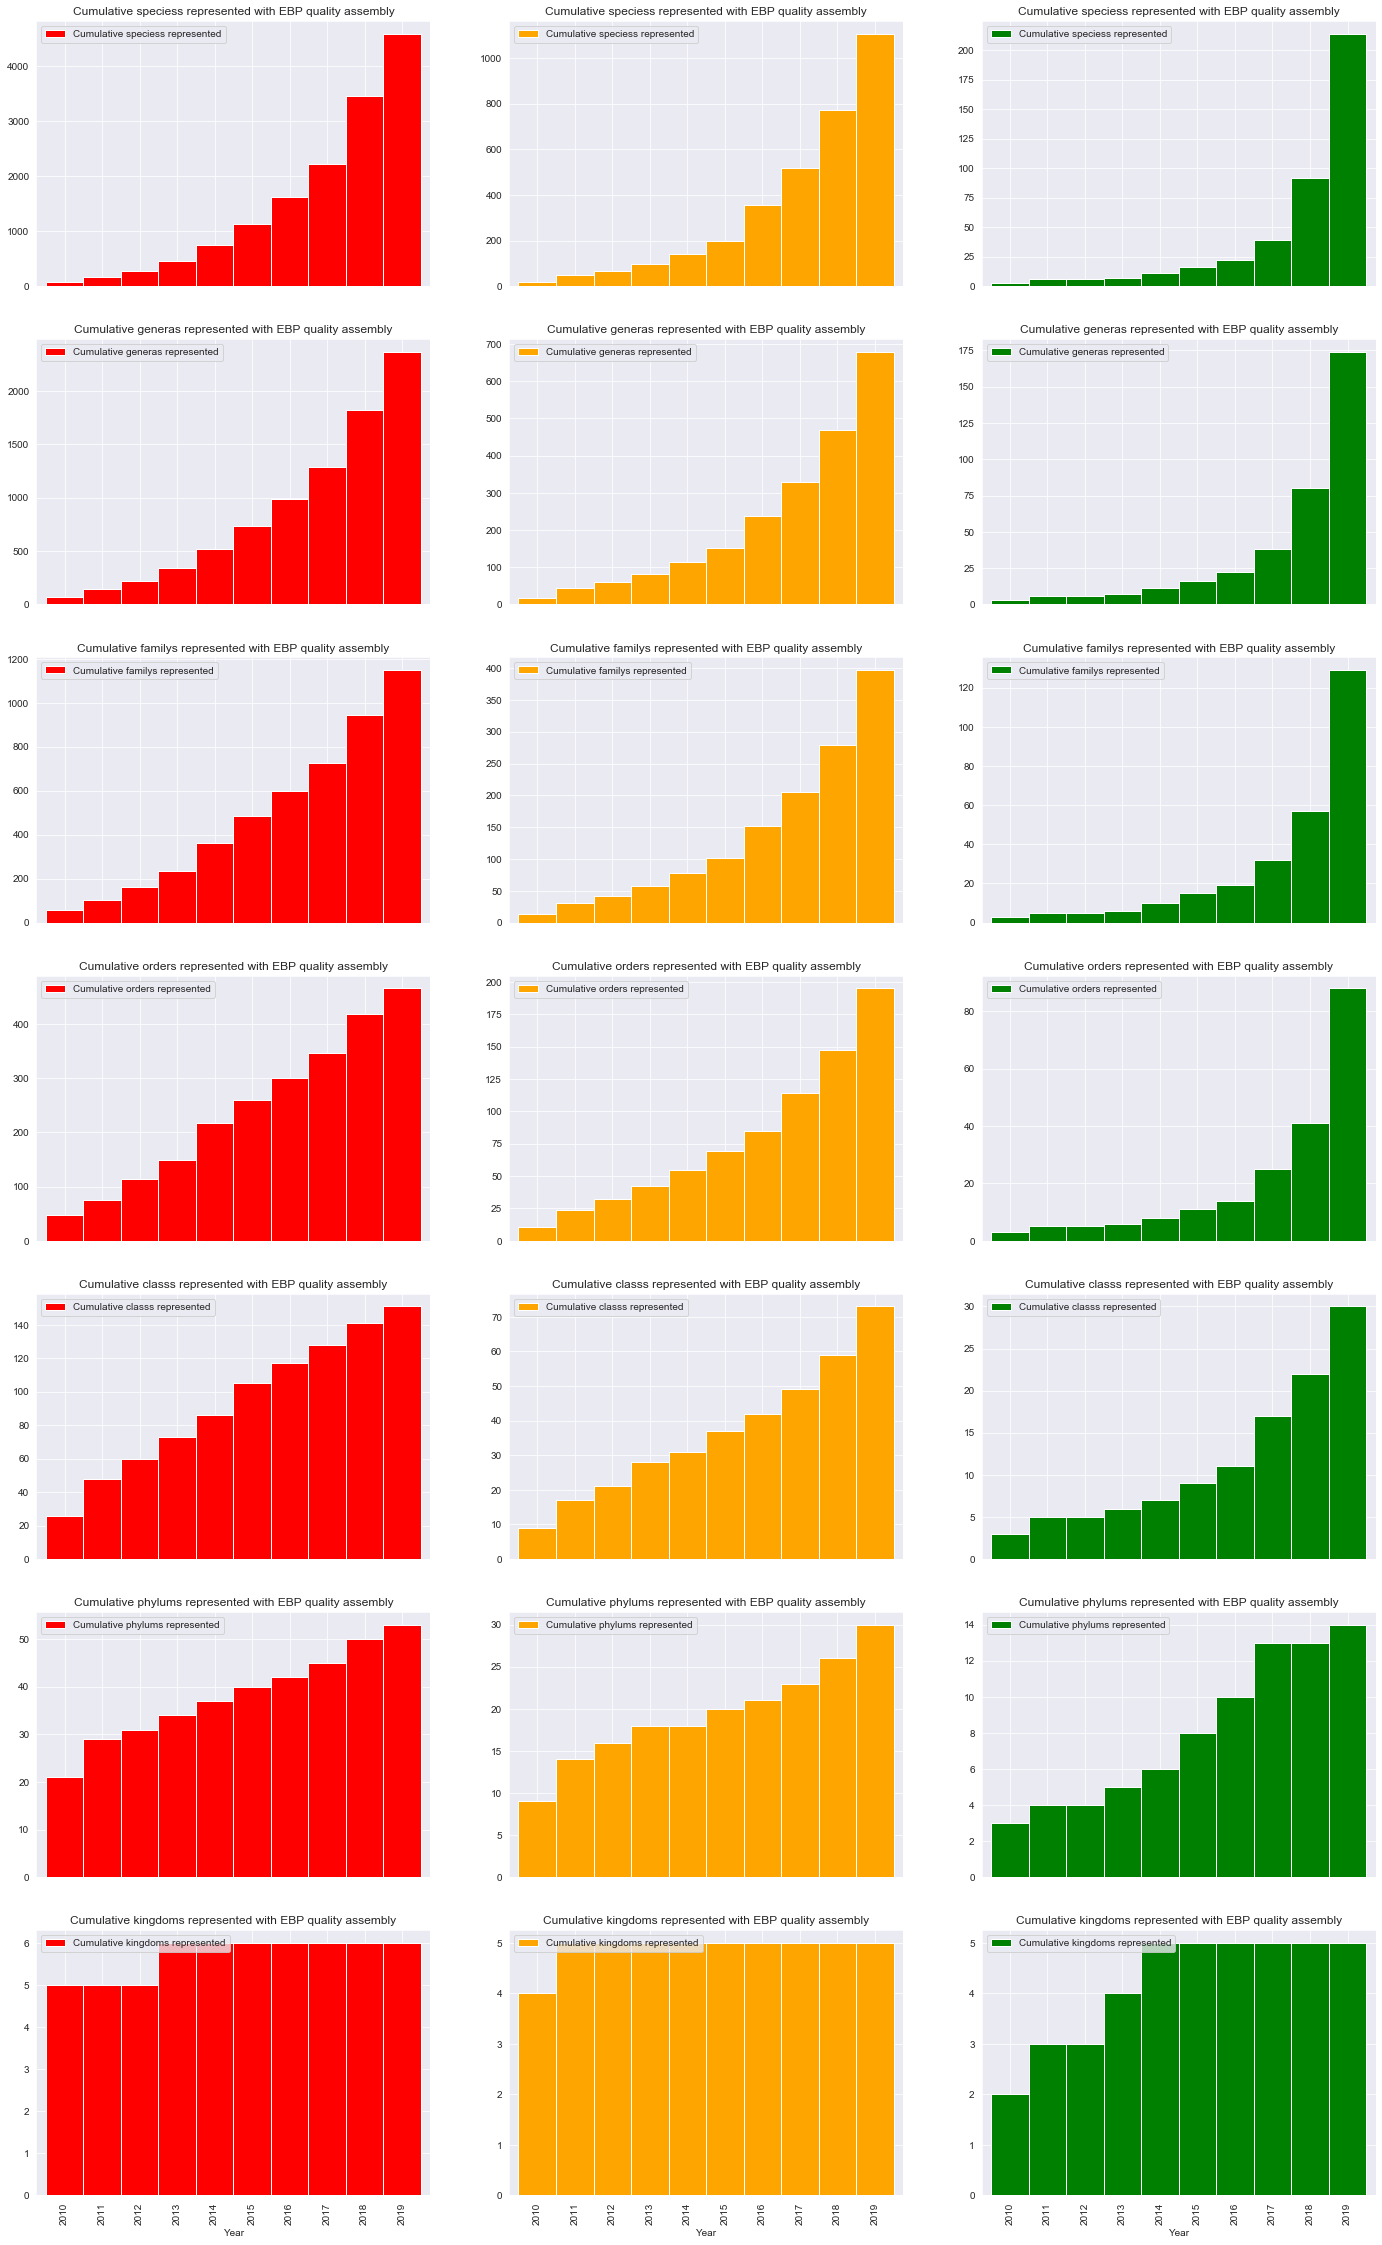

In [32]:
# trying to get all the charts in a single loop
df_sorted_no_dups.name = 'all'  # I named them for the coloring below
df_draft_all_passing.name = 'draft'
df_all_passing.name = 'VGP'

sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=7, ncols=3, squeeze=False, figsize=(24,40), sharex=True)

for loop_dfs in (df_sorted_no_dups, df_draft_all_passing, df_all_passing):
    print("\ntotal species at this quality = ", loop_dfs['species'].count())
    for rank in ('species', 'genera', 'family', 'order', 'class', 'phylum', 'kingdom'):
        taxon_column = "Cumulative " + rank + "s represented"
        cols = ['Year', taxon_column]
        lst = []

        for year_count in range(min_year, max_year+1):
            #print("year = ", year_count)
            #print(df_all_passing[df_all_passing['year'] <= year_count]['species'].count())
            #print(loop_dfs[loop_dfs['year'] <= year_count]['species'].count())
            
            #familes_with_assembly = pd.pivot_table(df_all_passing[df_all_passing['year'] <= year_count], index=[rank])['contig_n50'].count()
            familes_with_assembly = pd.pivot_table(loop_dfs[loop_dfs['year'] <= year_count], index=[rank])['contig_n50'].count()
            
            #print("number of cumulative ", rank, " passing = ",  familes_with_assembly)
            lst.append([int(year_count), int(familes_with_assembly)])

        df_cumulative_families_represented = pd.DataFrame(lst, columns=cols)
        #df_cumulative_families_represented.set_index('Year', inplace=True)
        #print(df_cumulative_families_represented)

        title_label = taxon_column + " with EBP quality assembly"
        bar_color = 'orange'
        plot_col = 0
        plot_row = 0
        
        if loop_dfs.name == "all":
            bar_color = 'red'
            plot_col = 0
        elif loop_dfs.name == 'draft':
            bar_color = 'orange'
            plot_col = 1
        elif loop_dfs.name == 'VGP':
            bar_color = 'green'
            plot_col = 2
        
        if rank == 'species':
            plot_row = 0
        elif rank == 'genera':
            plot_row = 1
        elif rank == 'family':
            plot_row = 2      
        elif rank == 'order':
            plot_row = 3
        elif rank == 'class':
            plot_row = 4
        elif rank == 'phylum':
            plot_row = 5
        elif rank == 'kingdom':
            plot_row = 6

        df_cumulative_families_represented.plot(ax=axes[plot_row, plot_col], x='Year', y=taxon_column, kind='bar', width=1, color=bar_color, title=title_label )

plt.savefig('NCBI_Genome_stats_images/taxonomic_rank_progress_by_year.png')

### Now I need to break out the numbers by kingdom and phyla for the reporter ###

In [33]:
df_sorted_no_dups['kingdom'].describe()

count      4435
unique        6
top       Fungi
freq       1920
Name: kingdom, dtype: object

In [34]:
df_sorted_no_dups['kingdom'].unique()

array(['Animalia', None, 'Plantae', 'Protozoa', 'Fungi', 'Chromista',
       'incertae sedis'], dtype=object)

Incertae sedis (Latin for "of uncertain placement") or problematica are terms used for a taxonomic group where its broader relationships are unknown or undefined. (Thanks Wikipedia!)

In [35]:
print("number of plants:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='Plantae']['species'].count())
print("number of animals:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='Animalia']['species'].count())
print("number of fungi:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='Fungi']['species'].count())
print("number of None:", df_sorted_no_dups[df_sorted_no_dups['kingdom']==None]['species'].count())
print("number of Protozoa:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='Protozoa']['species'].count())
print("number of Chromista:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='Chromista']['species'].count())
print("number of incertae sedis:", df_sorted_no_dups[df_sorted_no_dups['kingdom']=='incertae sedis']['species'].count())

number of plants: 537
number of animals: 1653
number of fungi: 1920
number of None: 0
number of Protozoa: 135
number of Chromista: 187
number of incertae sedis: 3


In [36]:
df_species_seq_in_each_kingdom = pd.pivot_table(data=df_sorted_no_dups, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_kingdom

,species
kingdom,
Animalia,1653
Chromista,187
Fungi,1920
Plantae,537
Protozoa,135
incertae sedis,3


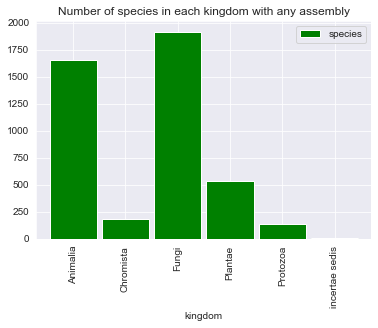

In [37]:
df_species_seq_in_each_kingdom.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each kingdom with any assembly')
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_kingdom.png')

In [38]:
df_species_seq_in_each_phylum = pd.pivot_table(data=df_sorted_no_dups, index='phylum', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_phylum

,species
phylum,
Amoebozoa,24
Annelida,6
Arthropoda,490
Ascomycota,1398
Basidiomycota,430
Bigyra,8
Brachiopoda,1
Bryophyta,2
Cephalorhyncha,1


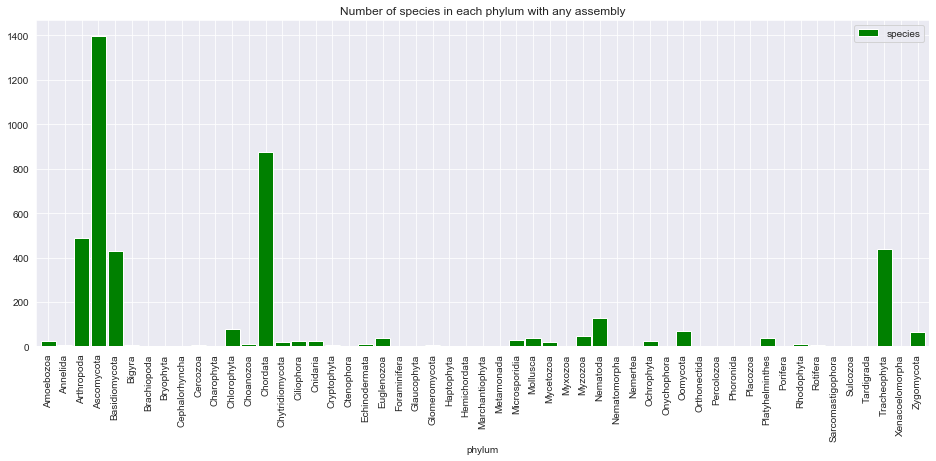

In [39]:
df_species_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with any assembly', figsize=(16,6))
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_phylum.png')

In [40]:
df_species_draft_seq_in_each_kingdom = pd.pivot_table(data=df_draft_all_passing, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_kingdom

,species
kingdom,
Animalia,327
Chromista,27
Fungi,568
Plantae,124
Protozoa,14


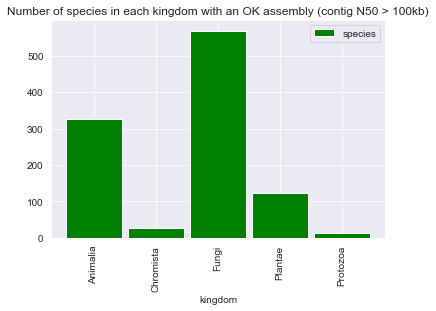

In [41]:
df_species_draft_seq_in_each_kingdom.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each kingdom with an OK assembly (contig N50 > 100kb)')

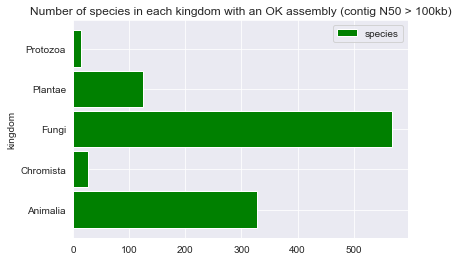

In [42]:
df_species_draft_seq_in_each_kingdom.plot(y='species', kind='barh', width=0.9, color='Green', title='Number of species in each kingdom with an OK assembly (contig N50 > 100kb)')

#### Using the number of species in each kingdom:  
Animal species: 1,312,087  
Plant species: 417,657  
Fungi species: 135,248  
Chromista species: 25,452  
Protozoa species: 2,705  
total eukaryotes: 1,893,149  

In [43]:
# total number of species in each kingdom = 

df_for_Esben = pd.DataFrame({'Kingdom' : ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa'], 
                            'Species' : [1312087, 417657, 135248, 25452, 2705],
                            'Sequenced' : [1595, 521, 1883, 178, 129],
                            })
#df_for_Esben = pd.merge(df_for_Esben, df_species_seq_in_each_kingdom['species'], how='right')
df_for_Esben['% Sequenced'] = df_for_Esben['Sequenced']/df_for_Esben['Species'] * 100
df_for_Esben.set_index('Kingdom', inplace=True)
df_for_Esben

,Species,Sequenced,% Sequenced
Kingdom,,,
Animalia,1312087,1595,0.121562
Plantae,417657,521,0.124744
Fungi,135248,1883,1.392257
Chromista,25452,178,0.699356
Protozoa,2705,129,4.768946


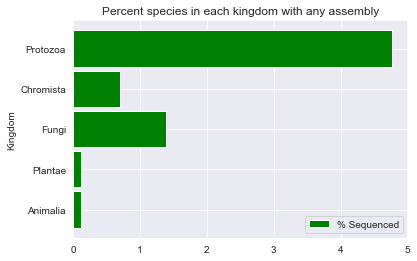

In [44]:
#order = ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa']
df_for_Esben.plot(y='% Sequenced', kind='barh', width=0.9, color='Green', title='Percent species in each kingdom with any assembly')
plt.savefig('NCBI_Genome_stats_images/Percennt_any_assembly_by_kingdom.png')

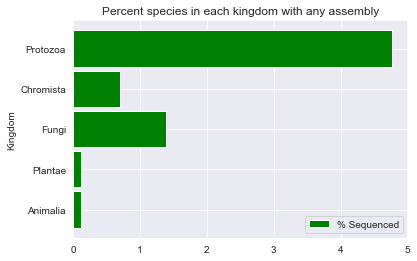

In [45]:
df_plot_for_Esben = pd.DataFrame({'Kingdom' : ['Animalia', 'Plantae', 'Fungi', 'Chromista', 'Protozoa'], 
                            '% Sequenced' : [0.121562, 0.124744, 1.392257, 0.699356, 4.768946],
                                 })
df_plot_for_Esben.set_index('Kingdom', inplace=True)
df_plot_for_Esben.plot(y='% Sequenced', kind='barh', width=0.9, color='Green', title='Percent species in each kingdom with any assembly')

In [46]:
df_species_seq_in_each_kingdom = pd.pivot_table(data=df_sorted_no_dups, index='kingdom', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_seq_in_each_kingdom

,species
kingdom,
Animalia,1653
Chromista,187
Fungi,1920
Plantae,537
Protozoa,135
incertae sedis,3


In [47]:
df_species_seq_in_each_kingdom = pd.merge(df_species_seq_in_each_kingdom, df_for_Esben, right_on='kingdom')

TypeError: object of type 'NoneType' has no len()

In [48]:
df_species_draft_seq_in_each_phylum = pd.pivot_table(data=df_draft_all_passing, index='phylum', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_phylum

,species
phylum,
Amoebozoa,1
Arthropoda,74
Ascomycota,445
Basidiomycota,111
Bigyra,1
Bryophyta,1
Cercozoa,1
Chlorophyta,8
Choanozoa,2


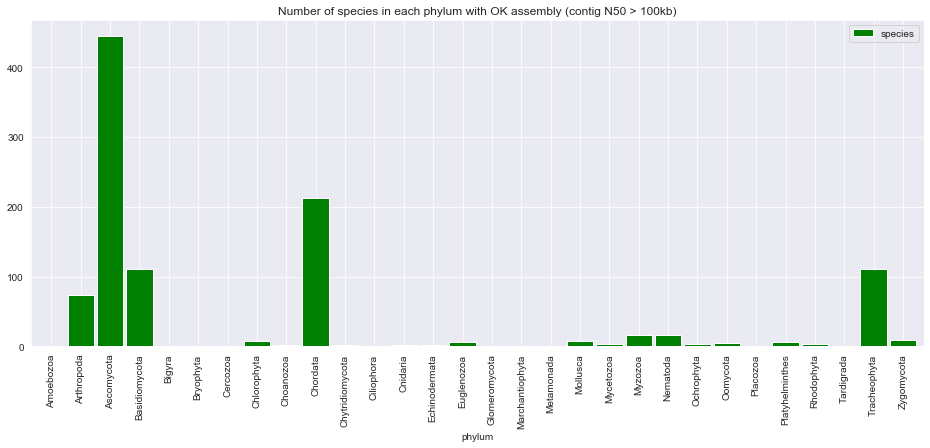

In [49]:
df_species_draft_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with OK assembly (contig N50 > 100kb)', figsize=(16,6))

In [50]:
df_species_draft_seq_in_each_class = pd.pivot_table(data=df_draft_all_passing, index='class', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_class

,species
class,
Actinopterygii,69
Adenophorea,2
Agaricomycetes,42
Agaricostilbomycetes,1
Amphibia,4
...,...
Tremellomycetes,40
Trepomonadea,1
Ulvophyceae,1


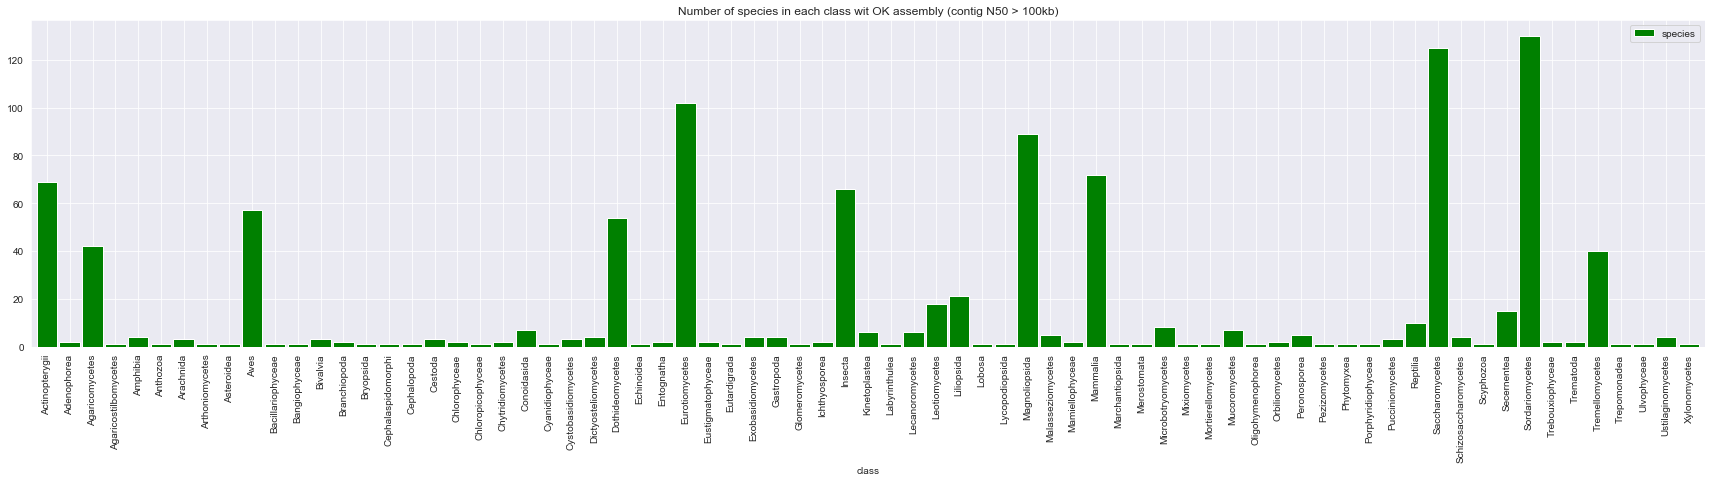

In [51]:
df_species_draft_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of species in each class wit OK assembly (contig N50 > 100kb)', figsize=(30,6))
#df_species_draft_seq_in_each_phylum.plot(y='species', kind='bar', width=0.9, color='Green', title='Number of species in each phylum with OK assembly (contig N50 > 100kb)', figsize=(16,6))
plt.savefig('NCBI_Genome_stats_images/OK_assemblies_by_class.png')

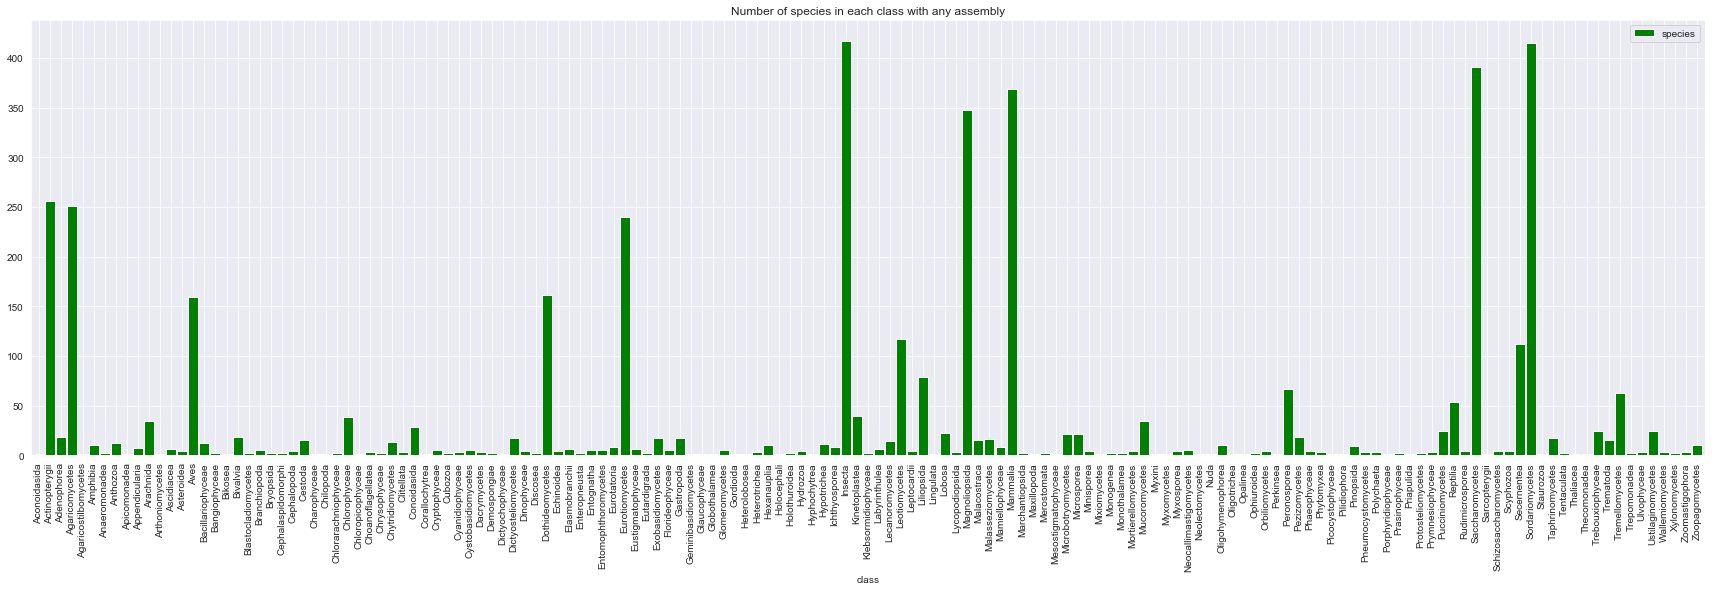

In [52]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups, index='class', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of species in each class with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/All_assemblies_by_class.png')

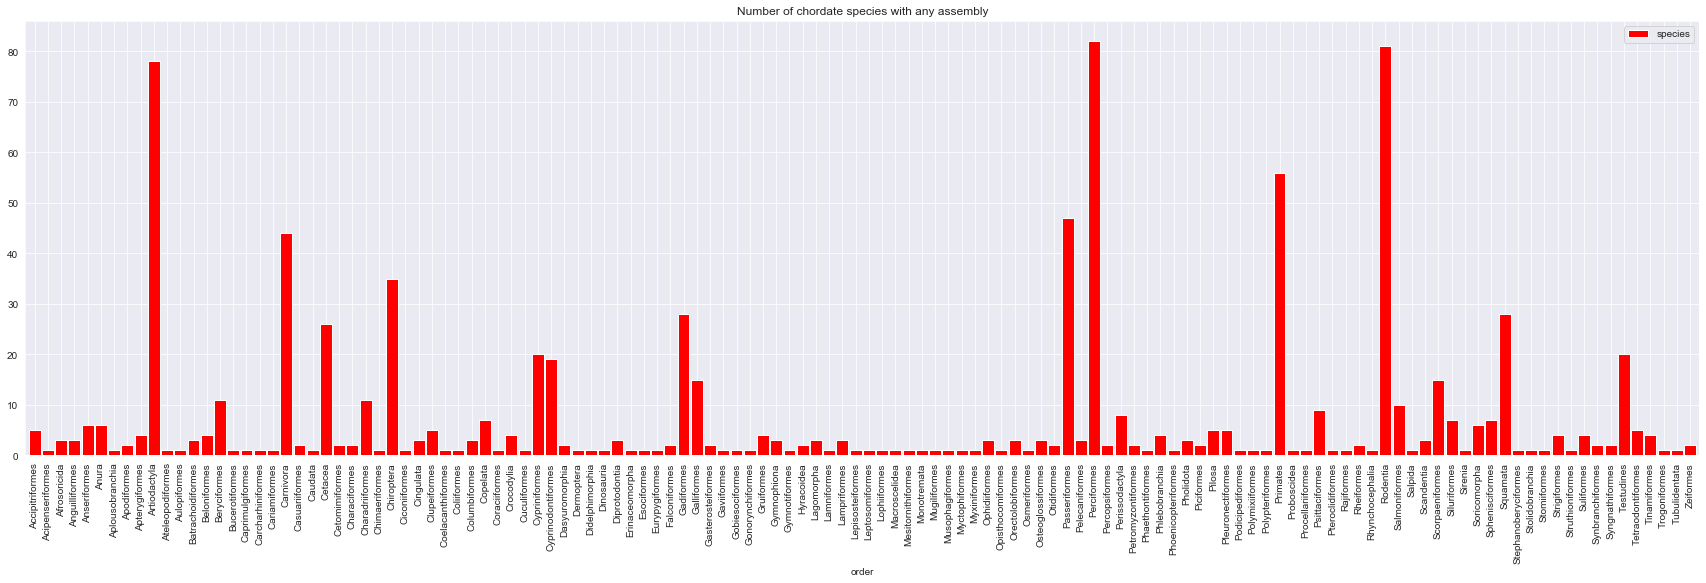

In [53]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups[df_sorted_no_dups['phylum']=='Chordata'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='red', title='Number of chordate species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_chordate_assembly_by_order.png')

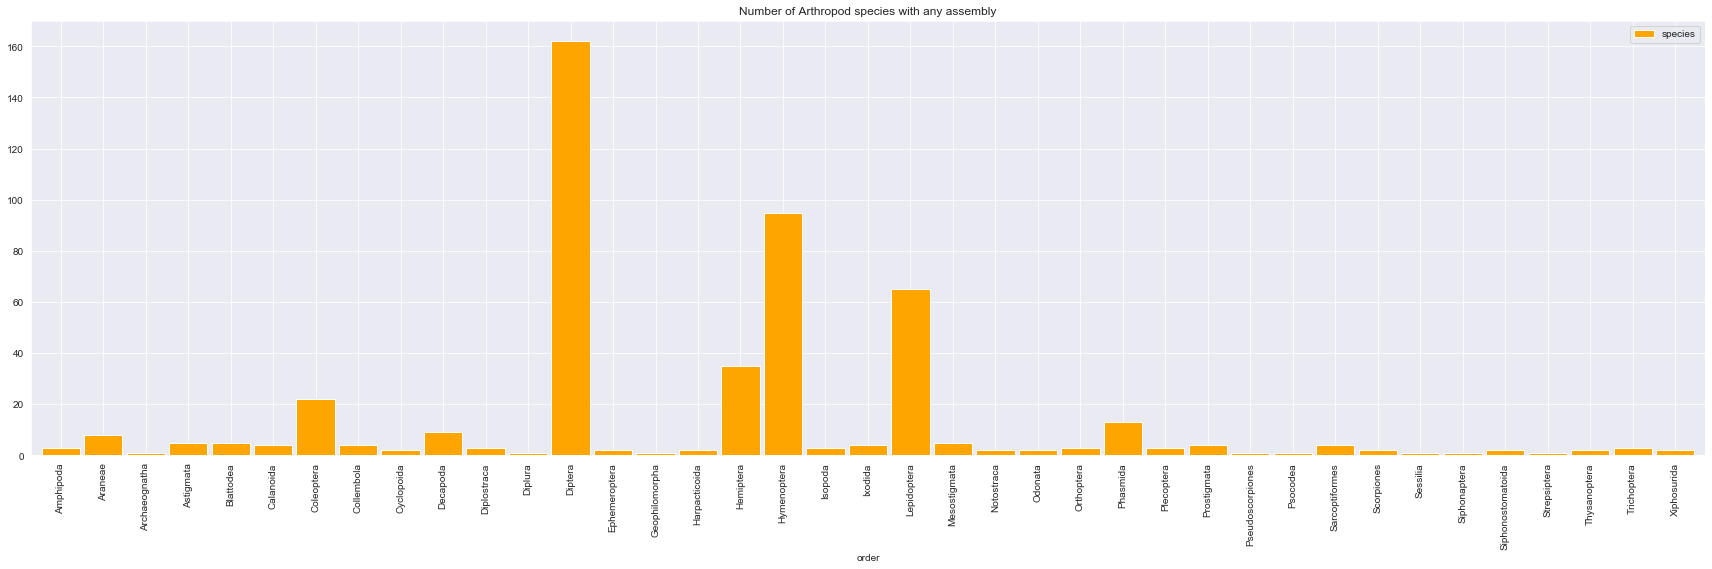

In [54]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups[df_sorted_no_dups['phylum']=='Arthropoda'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='orange', title='Number of Arthropod species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_arthropod_assembly_by_order.png')

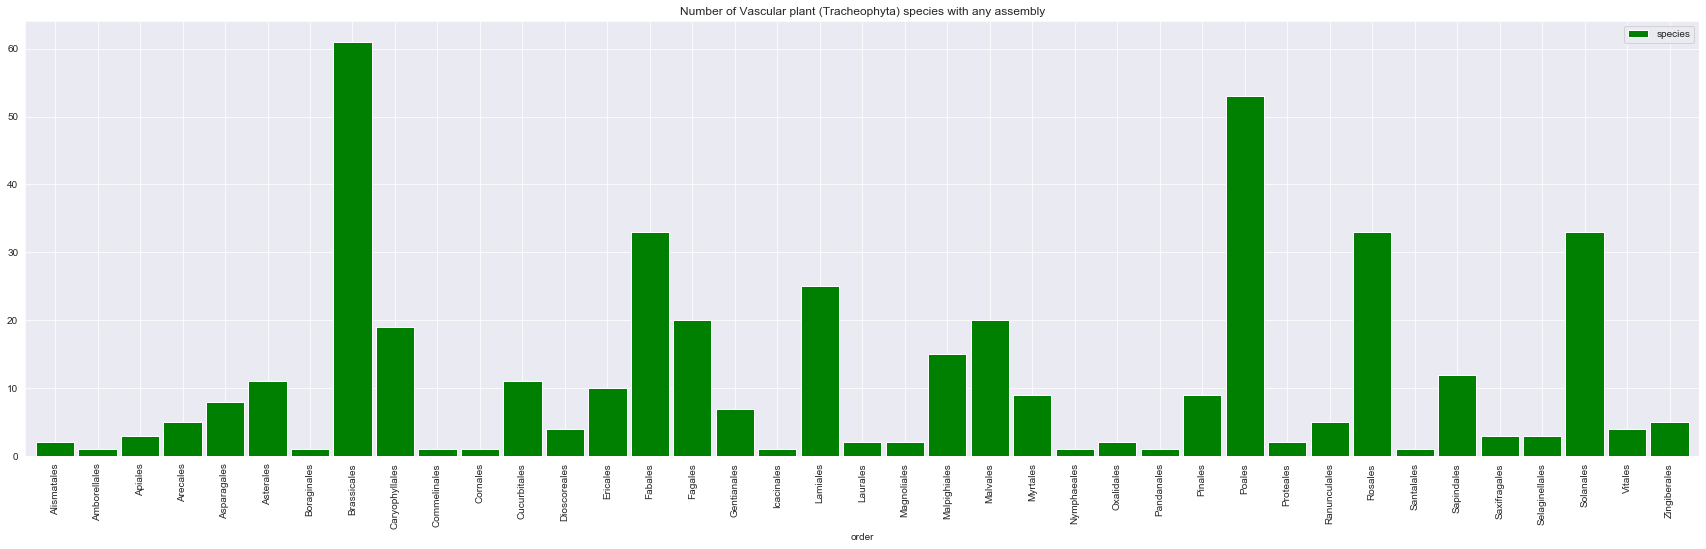

In [55]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups[df_sorted_no_dups['phylum']=='Tracheophyta'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of Vascular plant (Tracheophyta) species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_vascular_plant_assembly_by_order.png')

/Users/stephenr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


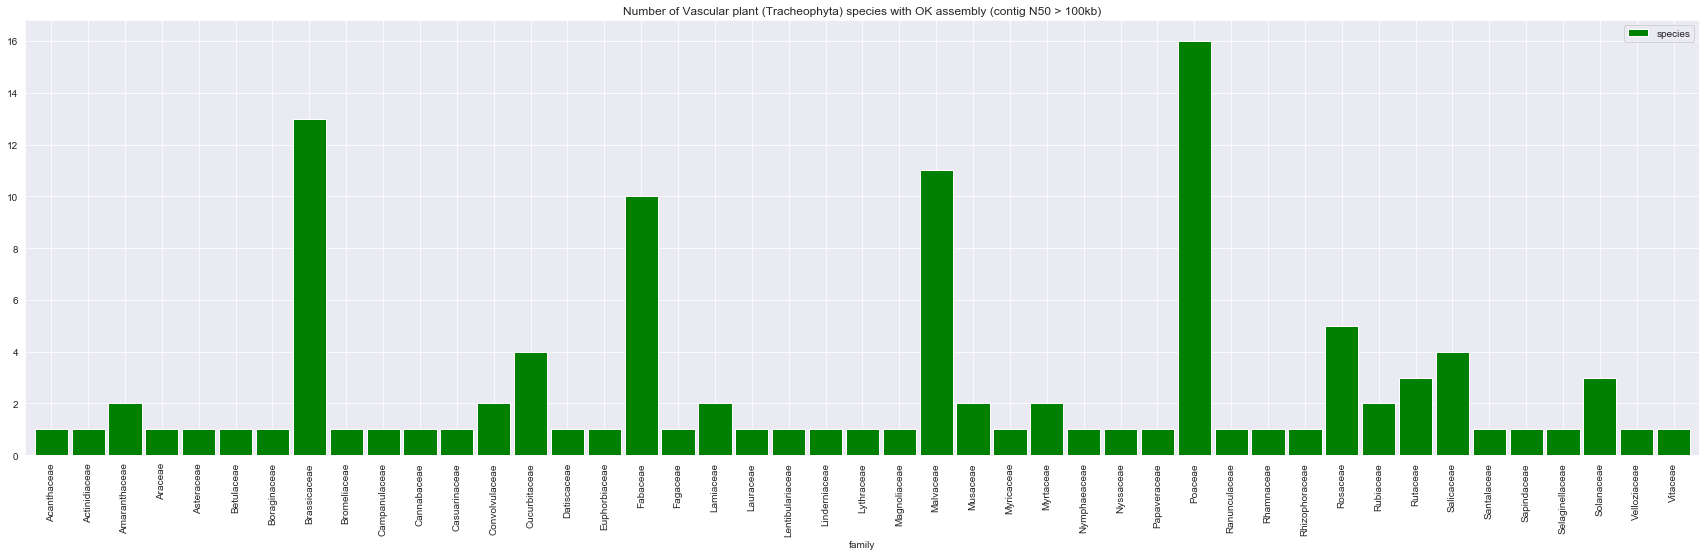

In [56]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_draft_all_passing[df_sorted_no_dups['phylum']=='Tracheophyta'], index='family', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='green', title='Number of Vascular plant (Tracheophyta) species with OK assembly (contig N50 > 100kb)', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/OK_vascular_plant_assemblies_by_family.png')

### World EBP progress plot for poster ###

In [57]:
!pwd

/Users/stephenr/Programing


In [60]:
# Import libraries
import pandas as pd
import folium
import os
 
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
#state_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'us-states.json')
world_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'world-countries.json')

# Load the progress value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
world_progress = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'World-countries_progress.csv')
world_data = pd.read_csv(world_progress)
 
# Initialize the map:
m = folium.Map(location=[37, 0], zoom_start=2)
#m = folium.Map(location=[45.5236, -122.6750])  # Folium is really cool,  I need to learn more about how to use it!
# Add the color for the chloropleth:
m.choropleth(
 geo_data=world_geo,
 name='choropleth',
 data=world_data,
 columns=['Country', 'Progress'],
 key_on='feature.properties.name',
# fill_color='BuGn',  # bit cold
# fill_color='BuPu', # Seems OK - not for me
# fill_color='GnBu',  # No
# fill_color='OrRd',  # seems OK - This is a good one
# fill_color='PuBu',  # Bit icy - No. 
# fill_color='PuBuGn',  # bit cold too
# fill_color='PuRd',    # not with a blue background
# fill_color='RdPu',   # not for me?
# fill_color='YlGn',    # I think we can do better
# fill_color='YlGnBu',   # not bad - but needs a different sea color
# fill_color='YlOrBr',  # good contrast easy to work with - not pretty??
 fill_color='YlOrRd',   # this is pretty good - contender - goood clarity - went with this in the end!!!
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Country EBP organization progress (%)', 
    
)
folium.LayerControl().add_to(m)

 
# Save to html - which you have to open in a broswer!
m.save('EBP_organization_progress_#292_folium_chloropleth_world1.html')
m

### And again - but this time with locations of EBP partners

In [62]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
#state_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'us-states.json')
world_geo = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'world-countries.json')


# Load the progress value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
world_progress = os.path.join('/Users/stephenr/Programing/NCBI_Genome_stats_images/', 'World-countries_progress.csv')
world_data = pd.read_csv(world_progress)

# load the locations of each EBP Partner:
# note - to find the lat and long, finnd location on gooogle maps, right click and find "What's here?" which will give youo a popup with clickable co-ordinates
df_ebp_partner_locations = pd.read_excel('NCBI_Genome_stats_images/locations_of_EBP_members_with_rockefeller.xlsx')
df_ebp_partner_locations.tail(3)
 
# Initialize the map:
# Add the USGS style map
#url_base = 'http://server.arcgisonline.com/'
#tiles = 'ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
#tileset = url_base + tiles

#m = folium.Map(location=[37, 0], zoom_start=2, control_scale = True, tiles=tileset, attr='USGS style')
m = folium.Map(location=[37, 0], zoom_start=2)


#m = folium.Map(location=[45.5236, -122.6750])  # Folium is really cool,  I need to learn more about how to use it!
# Add the color for the chloropleth:
m.choropleth(
 geo_data=world_geo,
 name='choropleth',
 data=world_data,
 columns=['Country', 'Progress'],
 key_on='feature.properties.name',
 fill_color='YlOrRd',   # after lookng at the others, this is pretty good - contender - good clarity
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Country EBP organization progress (%)', 
    
)
#folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)
 
for i in range(0,len(df_ebp_partner_locations)):
    #print(df_ebp_partner_locations.iloc[i]['latitude'],  df_ebp_partner_locations.iloc[i]['longitude'], df_ebp_partner_locations.iloc[i]['name'])
    folium.Marker([df_ebp_partner_locations.iloc[i]['latitude'], df_ebp_partner_locations.iloc[i]['longitude']], popup=df_ebp_partner_locations.iloc[i]['name'],
                 tooltip=df_ebp_partner_locations.iloc[i]['name'], size=2, radius=5, fill_color='green', color='black', fill_opacity=1, line_opacity=0.1).add_to(m)

#folium.Marker([38.535259, -121.765264], popup='<i>UC Davis Genome Center</i>', tooltip='UC Davis', icon=folium.Icon(color='red'),).add_to(m)
#folium.Marker([52.1874, 0.1208], popup='<i>Sanger Center Center</i>', tooltip='Sanger Center').add_to(m)
#folium.Marker([22.571336, 114.448035], popup='<i>BGI</i>', tooltip='BGI').add_to(m)


#m.add_child(folium.LatLngPopup())
    
# Save to html
m.save('EBP_partner_locations_#292_folium_chloropleth_world1.html')
m